In [1]:
# import dependencies
# !pip uninstall umap --yes
# !pip install umap-learn
# !pip install cuml

# !pip install numba

# !pip install joblib

import pandas as pd
import json
import xgboost
import lightgbm
import gc
import numpy as np
import joblib

# import umap

import umap.umap_ as umap

pd.options.mode.chained_assignment = None  # default='warn'

numeraiDir = '.'
import numeraiutils as num


from utils import (
    save_model,
    load_model,
    neutralize,
    get_biggest_change_features,
    get_time_series_cross_val_splits,
    validation_metrics,
    load_model_config,
    save_model_config,
    save_prediction,
    TARGET_COL,
)




/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
target='target'
keys = ['era', 'data_type', target]

# In[ load data ]
print('Loading data')

f = open('features.json')
j = json.load(f)

train = pd.read_parquet('numerai_training_data_int8.parquet')
val = pd.read_parquet('numerai_validation_data_int8.parquet')
td = pd.read_parquet('numerai_tournament_data_int8.parquet')


train_small = train.sample(n=200000)


Loading data


In [3]:
# all features
# features = [c for c in train if c.startswith("feature")]

# selected features for speed
features = j['feature_sets']['medium'] # small / medium / legacy

targets = [c for c in train if c.startswith("target")]

train = train_small[keys + features]
val = val[keys + features]
td = td[keys + features]



In [ ]:
train.to_csv('train_selection_2505.csv')

In [4]:
# In[ baseline model ]

params = {
            "n_estimators": 1000,
            "learning_rate": 0.01,
            "max_depth": 5,
            "num_leaves": 2 ** 5,
            "colsample_bytree": 0.1
        }
    
# est = lightgbm.LGBMRegressor(**params)

# est.fit(train[features], train[target])
# val['pred'] = est.predict(val[features])

# num.evaluation(val, features)
# val = val.rename(columns={'pred':'prediction'})
# val['prediction'].to_csv('validation_baseline_lgbm.csv')

# est.booster_.save_model('lgb_umap.txt') # Save model

In [5]:
import lightgbm
import seaborn as sns
import matplotlib.pyplot as plt
model = lightgbm.Booster(model_file='lgb_umap.txt') # Load model if already trained and saved


pd.DataFrame(model.feature_importance(), index=features, columns=['importance']).sort_values(by='importance', ascending=False).style.background_gradient(cmap='viridis')


,importance
feature_unvaried_social_bangkok,320
feature_whopping_eminent_attempter,210
feature_hexametric_ventricose_limnology,190
feature_jerkwater_eustatic_electrocardiograph,189
feature_migrant_reliable_chirurgery,170
feature_caespitose_unverifiable_intent,167
feature_dipped_sent_giuseppe,166
feature_travelled_semipermeable_perruquier,164
feature_venatic_intermetallic_darling,160
feature_alkaline_pistachio_sunstone,160


In [6]:
importances = pd.DataFrame(model.feature_importance(), index=features, columns=['importance']).sort_values(by='importance', ascending=False)
features_top_100 = importances.head(100)
features_top_100


,importance
feature_unvaried_social_bangkok,320
feature_whopping_eminent_attempter,210
feature_hexametric_ventricose_limnology,190
feature_jerkwater_eustatic_electrocardiograph,189
feature_migrant_reliable_chirurgery,170
...,...
feature_endangered_unthreaded_firebrick,104
feature_loricate_cryptocrystalline_ethnology,104
feature_levigate_kindly_dyspareunia,103
feature_chelonian_pyknic_delphi,103


In [7]:
top_100_features = features_top_100.index.tolist()
top_100_features

['feature_unvaried_social_bangkok',
 'feature_whopping_eminent_attempter',
 'feature_hexametric_ventricose_limnology',
 'feature_jerkwater_eustatic_electrocardiograph',
 'feature_migrant_reliable_chirurgery',
 'feature_caespitose_unverifiable_intent',
 'feature_dipped_sent_giuseppe',
 'feature_travelled_semipermeable_perruquier',
 'feature_venatic_intermetallic_darling',
 'feature_alkaline_pistachio_sunstone',
 'feature_base_ingrain_calligrapher',
 'feature_unluckiest_mulley_benzyl',
 'feature_uncharged_unovercome_smolder',
 'feature_ambisexual_boiled_blunderer',
 'feature_koranic_rude_corf',
 'feature_sudsy_polymeric_posteriority',
 'feature_atlantic_uveal_incommunicability',
 'feature_scenic_cormophytic_bilirubin',
 'feature_renegade_undomestic_milord',
 'feature_vedic_mitral_swiz',
 'feature_contaminative_intrusive_tagrag',
 'feature_questionable_diplex_caesarist',
 'feature_fissirostral_multifoliate_chillon',
 'feature_trim_axial_suffocation',
 'feature_integrated_extroversive_ambi

In [34]:
# Numerai score (spearman correlation): 0.0208, STD: 0.0329
# Sharpe ratio: 0.6320
# Sortino ratio: 1.6578
# Max drawdown: -0.19033823759034238
# Max feature exposure:  0.4509352785060702

# In[ fit umap model with full dataset that includes validation and tournament data]

n_neighbors = 15
min_dist = 0
n_components = 60

train_full = pd.concat([train, val, td[::10]]).reset_index()
train_tr = pd.concat([train, val]).reset_index()


umap = umap.UMAP(n_neighbors = n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)
data = umap.fit_transform(train_full[top_100_features])


#save UMAP-model
filename = 'LGBM_UMAP_MODEL.pkl'
joblib.dump(umap, filename)

umap_features = [f'f_{i}' for i in range(data.shape[1])]

pData = pd.DataFrame(data, columns=umap_features).iloc[:len(train_tr)]
new_train_ft = pd.concat([train_tr, pData], axis=1)    
new_features_ft = top_100_features + umap_features

# del train_full
# del train_tr
# del umap
# del data
# del pData

gc.collect()




# print(type(loaded_reducer))
# # <class 'umap.umap_.UMAP'>

# # with pickle
# import pickle

# f_name = 'saving_example.sav'
# pickle.dump(reducer, open(f_name, 'wb'))

# # time passes
# loaded_model = pickle.load((open(f_name, 'rb')))
# print(type(loaded_model))
# # <class 'umap.umap_.UMAP'>


59825

### Load UMAP model

In [8]:
filename = 'LGBM_UMAP_MODEL.pkl'
model = joblib.load(filename)


In [9]:
print(model)

UMAP(min_dist=0, n_components=60, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


In [9]:
td.data_type.unique()

array(['test', 'live'], dtype=object)

In [12]:
n_neighbors = 15
min_dist = 0
n_components = 60

# train_full = pd.concat([train, val, td[::10]]).reset_index()
tournament_data = td.reset_index()


# umap = umap.UMAP(n_neighbors = n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)
umap_tr = model
data = umap_tr.transform(tournament_data[top_100_features])


#save UMAP-model
# filename = 'LGBM_UMAP_MODEL.sav'
# joblib.dump(data, filename)

umap_features = [f'f_{i}' for i in range(data.shape[1])]

pData = pd.DataFrame(data, columns=umap_features).iloc[:len(tournament_data)]
new_train = pd.concat([tournament_data, pData], axis=1)    
new_features = top_100_features + umap_features

# del train_full
# del train_tr
# del umap
# del data
# del pData

gc.collect()

55487

In [25]:
pdata.to_csv('pdata_umap_tournament_2405.csv')

NameError: name 'pdata' is not defined

In [14]:
new_train.to_csv('new_train_umap_tournament_2405')

In [21]:
umap_train_data = pd.concat([train_tr, pData], axis=1) 

In [27]:
new_train.head()

,id,era,data_type,target,feature_abstersive_emotional_misinterpreter,feature_accessorial_aroused_crochet,feature_acerb_venusian_piety,feature_affricative_bromic_raftsman,feature_agile_unrespited_gaucho,feature_agronomic_cryptal_advisor,...,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59,pred
0,n000101811a8a843,0575,test,NaN,0,2,2,0,0,4,...,5.347478,4.879547,4.954859,5.124501,4.902417,5.001768,4.923327,5.408041,4.845487,0.499022
1,n001e1318d5072ac,0575,test,NaN,4,3,0,3,2,4,...,4.960277,5.329504,4.716099,5.227285,5.568428,4.671676,5.071088,4.905796,4.838717,0.511947
2,n002a9c5ab785cbb,0575,test,NaN,4,0,0,4,0,3,...,5.251763,5.306345,4.396791,5.069369,5.492251,4.885715,5.202935,5.023580,4.931827,0.496736
3,n002ccf6d0e8c5ad,0575,test,NaN,4,0,1,4,0,0,...,4.518621,5.321073,5.141388,5.193885,5.623876,4.249706,4.924946,4.999807,5.347631,0.500519
4,n0051ab821295c29,0575,test,NaN,3,4,2,1,1,1,...,4.940565,5.406779,5.034078,5.274836,4.498862,5.234787,4.963216,5.768941,5.652868,0.503477


In [24]:


est = lightgbm.LGBMRegressor(**params)

# est = lightgbm.Booster(model_file='lgb_umap.txt')

est.fit(umap_train_data[new_features], umap_train_data[target])
new_train['pred'] = est.predict(new_train[new_features])
td['prediction'] = new_train['pred'].values
td['prediction'].to_csv('tournament_allFeatures_2405.csv')

In [8]:
new_train = pd.read_csv('new_train_1705.csv')

In [12]:
new_train.head()

,Unnamed: 0,id,era,data_type,target,feature_abstersive_emotional_misinterpreter,feature_accessorial_aroused_crochet,feature_acerb_venusian_piety,feature_affricative_bromic_raftsman,feature_agile_unrespited_gaucho,...,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59
0,0,n2ef3bfca38a5ce8,104,train,0.50,2,0,2,0,1,...,1.871976,6.140210,4.678768,3.338742,5.365781,2.784012,4.479485,5.080912,4.380979,1.313839
1,1,nff0a7b22816987a,137,train,0.25,3,1,1,0,2,...,1.902533,5.127774,4.476385,3.085600,5.096171,2.851546,4.300503,5.186644,3.899491,1.586067
2,2,n90e1ebcf2ce4c8b,285,train,0.50,0,2,1,1,0,...,2.081192,5.310861,4.332489,3.175396,5.064348,2.909001,4.351908,5.183597,3.906013,1.840040
3,3,n9af0779b41481d8,289,train,0.50,4,1,2,0,1,...,1.837483,5.384891,4.660140,3.018844,5.152778,2.978919,4.465791,4.585638,4.090950,1.390885
4,4,n339874aeac0acee,455,train,0.75,0,3,1,0,3,...,1.749842,4.867384,4.765368,2.977462,5.014893,2.758028,4.424798,4.829922,3.916106,1.589420


In [13]:
new_train = new_train.drop("Unnamed: 0", axis=1)

In [14]:
new_train

,id,era,data_type,target,feature_abstersive_emotional_misinterpreter,feature_accessorial_aroused_crochet,feature_acerb_venusian_piety,feature_affricative_bromic_raftsman,feature_agile_unrespited_gaucho,feature_agronomic_cryptal_advisor,...,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59
0,n2ef3bfca38a5ce8,104,train,0.50,2,0,2,0,1,0,...,1.871976,6.140210,4.678768,3.338742,5.365781,2.784012,4.479485,5.080912,4.380979,1.313839
1,nff0a7b22816987a,137,train,0.25,3,1,1,0,2,2,...,1.902533,5.127774,4.476385,3.085600,5.096171,2.851546,4.300503,5.186644,3.899491,1.586067
2,n90e1ebcf2ce4c8b,285,train,0.50,0,2,1,1,0,3,...,2.081192,5.310861,4.332489,3.175396,5.064348,2.909001,4.351908,5.183597,3.906013,1.840040
3,n9af0779b41481d8,289,train,0.50,4,1,2,0,1,1,...,1.837483,5.384891,4.660140,3.018844,5.152778,2.978919,4.465791,4.585638,4.090950,1.390885
4,n339874aeac0acee,455,train,0.75,0,3,1,0,3,4,...,1.749842,4.867384,4.765368,2.977462,5.014893,2.758028,4.424798,4.829922,3.916106,1.589420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639653,nffbe5152c321f92,961,validation,0.50,0,4,2,1,0,2,...,1.387866,5.343395,5.964894,3.406221,4.703737,4.260471,6.055661,4.747515,4.333748,-0.294101
639654,nffc011b4baa54c3,961,validation,0.50,2,4,3,3,1,0,...,3.645462,5.543088,4.646437,3.262859,4.714442,3.938163,3.020609,4.199531,2.838325,2.331362
639655,nffc12b2a846ab4e,961,validation,0.00,3,0,0,4,4,3,...,2.161895,5.989082,4.314276,4.603273,4.603912,3.315204,2.766803,4.137203,3.836290,1.598349
639656,nffc3c5ab0235de0,961,validation,0.50,4,2,3,4,4,0,...,1.969762,6.771115,5.312197,3.999235,4.115748,3.618758,4.662356,4.477850,5.408509,3.037408


In [16]:
new_features = [c for c in new_train if c.startswith("f")]

In [17]:
new_features

['feature_abstersive_emotional_misinterpreter',
 'feature_accessorial_aroused_crochet',
 'feature_acerb_venusian_piety',
 'feature_affricative_bromic_raftsman',
 'feature_agile_unrespited_gaucho',
 'feature_agronomic_cryptal_advisor',
 'feature_alkaline_pistachio_sunstone',
 'feature_altern_unnoticed_impregnation',
 'feature_ambisexual_boiled_blunderer',
 'feature_amoebaean_wolfish_heeler',
 'feature_amygdaloidal_intersectional_canonry',
 'feature_antipathetical_terrorful_ife',
 'feature_antipodal_unable_thievery',
 'feature_antisubmarine_foregoing_cryosurgery',
 'feature_apomictical_motorized_vaporisation',
 'feature_apophthegmatical_catechetical_millet',
 'feature_apostate_impercipient_knighthood',
 'feature_appraisive_anagrammatical_tentacle',
 'feature_arillate_nickelic_hemorrhage',
 'feature_armoured_finable_skywriter',
 'feature_assenting_darn_arthropod',
 'feature_assertive_worsened_scarper',
 'feature_atlantic_uveal_incommunicability',
 'feature_attuned_southward_heckle',
 'fea

In [9]:

# opening the file in read mode
my_file = open("new_features.txt", "r")
  
# reading the file
data = my_file.read()
  
# replacing end of line('/n') with ' ' and
# splitting the text it further when '.' is seen.
new_features = data.split("\n")
  
# printing the data
print(new_features)
my_file.close()

['feature_abstersive_emotional_misinterpreter', 'feature_accessorial_aroused_crochet', 'feature_acerb_venusian_piety', 'feature_affricative_bromic_raftsman', 'feature_agile_unrespited_gaucho', 'feature_agronomic_cryptal_advisor', 'feature_alkaline_pistachio_sunstone', 'feature_altern_unnoticed_impregnation', 'feature_ambisexual_boiled_blunderer', 'feature_amoebaean_wolfish_heeler', 'feature_amygdaloidal_intersectional_canonry', 'feature_antipathetical_terrorful_ife', 'feature_antipodal_unable_thievery', 'feature_antisubmarine_foregoing_cryosurgery', 'feature_apomictical_motorized_vaporisation', 'feature_apophthegmatical_catechetical_millet', 'feature_apostate_impercipient_knighthood', 'feature_appraisive_anagrammatical_tentacle', 'feature_arillate_nickelic_hemorrhage', 'feature_armoured_finable_skywriter', 'feature_assenting_darn_arthropod', 'feature_assertive_worsened_scarper', 'feature_atlantic_uveal_incommunicability', 'feature_attuned_southward_heckle', 'feature_autarkic_constabula

Numerai score (spearman correlation): 0.0543, STD: 0.0292
Sharpe ratio: 1.8581
Sortino ratio: 36.3926
Max drawdown: -0.014727323457879807
Max feature exposure:  0.23587282518574962



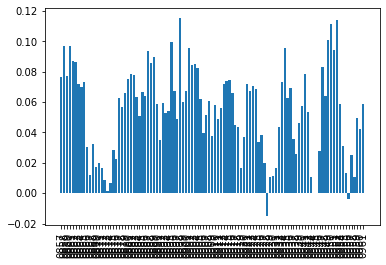

In [35]:
# In[ retrain estimator on the complete extended dataset ]

est = lightgbm.LGBMRegressor(**params)

est.fit(new_train_ft.loc[new_train_ft.data_type=='train', new_features_ft], new_train_ft.loc[new_train_ft.data_type=='train', target])
new_train_ft.loc[new_train_ft.data_type=='validation', 'pred'] = est.predict(new_train_ft.loc[new_train_ft.data_type=='validation', new_features_ft])
num.evaluation(new_train_ft[new_train_ft.data_type=='validation'], new_features_ft)


val['prediction'] = new_train_ft.loc[new_train_ft.data_type=='validation', 'pred'].values
val['prediction'].to_csv('validation_allFeatures_2505.csv')

In [19]:
from sklearn.preprocessing import MinMaxScaler
import scipy

def neutralize(df,
               columns,
               neutralizers=None,
               proportion=1.0,
               normalize=True,
               era_col="era"):
    if neutralizers is None:
        neutralizers = []
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        print(u, end="\r")
        df_era = df[df[era_col] == u]
        scores = df_era[columns].values
        if normalize:
            scores2 = []
            for x in scores.T:
                x = (scipy.stats.rankdata(x, method='ordinal') - .5) / len(x)
                x = scipy.stats.norm.ppf(x)
                scores2.append(x)
            scores = np.array(scores2).T
        exposures = df_era[neutralizers].values

        scores -= proportion * exposures.dot(
            np.linalg.pinv(exposures.astype(np.float32)).dot(scores.astype(np.float32)))

        scores /= scores.std(ddof=0)

        computed.append(scores)

    return pd.DataFrame(np.concatenate(computed),
                        columns=columns,
                        index=df.index)

In [36]:
# new_train.loc[new_train.data_type=='validation', 'pred'] = umap_val_preds
val['prediction_neutralized'] = neutralize(val, 
                                      columns=["prediction"], 
                                      neutralizers=features, 
                                      proportion=0.5, # neutralize by 50% within each era
                                      normalize=True,
                                      era_col='era') 

scaler = MinMaxScaler()
val['prediction_neutralized'] = scaler.fit_transform(val[['prediction_neutralized']]) # transform back to 0-1

0961

In [37]:
val = val.drop("prediction", axis=1)

In [38]:
val['prediction'] = val['prediction_neutralized']

In [39]:
val['prediction'].to_csv('validation_umapFeatures_neutralize_2505_scratch.csv')

In [25]:
val

,era,data_type,target,feature_abstersive_emotional_misinterpreter,feature_accessorial_aroused_crochet,feature_acerb_venusian_piety,feature_affricative_bromic_raftsman,feature_agile_unrespited_gaucho,feature_agronomic_cryptal_advisor,feature_alkaline_pistachio_sunstone,...,feature_westering_immunosuppressive_crapaud,feature_whistleable_unbedimmed_chokey,feature_whitened_remanent_blast,feature_whopping_eminent_attempter,feature_wieldable_defiled_aperitive,feature_wombed_reverberatory_colourer,feature_zarathustrian_albigensian_itch,feature_zymotic_varnished_mulga,prediction,prediction_neutralized
id,,,,,,,,,,,,,,,,,,,,,
n000777698096000,0857,validation,0.25,2,4,1,4,0,0,0,...,1,0,4,1,3,3,0,1,0.510747,0.648588
n0009793a3b91c27,0857,validation,0.50,3,4,4,4,4,0,0,...,4,3,2,2,3,2,0,2,0.516408,0.615564
n00099ccd6698ab0,0857,validation,0.00,0,1,4,3,1,0,1,...,4,4,3,4,0,0,3,3,0.506868,0.562500
n0019e36bbb8702b,0857,validation,0.50,1,0,2,0,1,4,4,...,1,0,2,1,1,4,2,0,0.482360,0.427172
n0028cb874439df8,0857,validation,0.50,2,3,0,4,2,3,2,...,3,3,0,3,3,1,4,4,0.464273,0.243840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffbe5152c321f92,0961,validation,0.50,0,4,2,1,0,2,1,...,4,0,4,0,1,2,0,0,0.488085,0.504424
nffc011b4baa54c3,0961,validation,0.50,2,4,3,3,1,0,0,...,2,1,2,4,0,1,1,1,0.480146,0.343249
nffc12b2a846ab4e,0961,validation,0.00,3,0,0,4,4,3,3,...,4,3,4,3,3,4,4,4,0.493292,0.476693


Numerai score (spearman correlation): 0.0172, STD: 0.0179
Sharpe ratio: 0.9582
Sortino ratio: 3.2621
Max drawdown: -0.06592234410334205
Max feature exposure:  0.22600613853820026



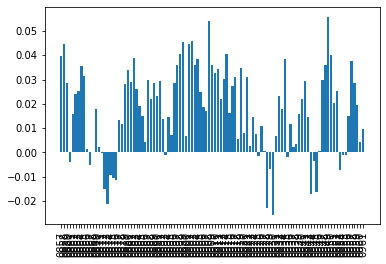

In [11]:
# In[ retrain estimator on the extended dataset only ]

est = lightgbm.LGBMRegressor(**params)
est.fit(new_train.loc[new_train.data_type=='train', umap_features], new_train.loc[new_train.data_type=='train', target])
new_train.loc[new_train.data_type=='validation', 'pred'] = est.predict(new_train.loc[new_train.data_type=='validation', umap_features])
num.evaluation(new_train[new_train.data_type=='validation'], features)

val['prediction'] = new_train.loc[new_train.data_type=='validation', 'pred'].values
val['prediction'].to_csv('validation_umapFeatures.csv')

# Numerai score (spearman correlation): 0.0073, STD: 0.0158
# Sharpe ratio: 0.4651
# Sortino ratio: 0.9302
# Max drawdown: -0.10544801045624015
# Max feature exposure:  0.07221613666926133
